# Predicting User Calls
* Predicting whether or not user will call customer support within the next 14 days

## Summary:
**Dataset:** Two datasets; train_set.csv contains user ids with features relating to their recent gameplay, customer_country.csv contains user ids with their corresponding country location.  
**Model:**  XGBoost classification model  
**Particulars:** Imbalanced dataset (comparing different sampling strategies), feature engineering, hyperparameter tuning

## Table of Contents:
* Section 0 - Data Exploration
* Section 1 - Customised Functions
* Section 2 - Data Preparation and Feature Engineering
* Section 3 - Hyperparameter Tuning
* Section 4 - Final Model
* Section 5 - Results

In [3]:
import pickle
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from skopt import BayesSearchCV
from skopt.space import Real
from skopt.space import Categorical
from skopt.space import Integer

from xgboost import XGBClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
print("Python version:", platform.python_version())

Python version: 3.7.12


In [5]:
pd.options.display.max_columns = None

## Section 0 - Data Exploration

1. Dataset contains no null values, and upon further investigation, require no further cleaning
2. Dataset is highly imbalanced between the two classes 55,515 vs 941
3. Datatypes for all columns are as expected

In [6]:
# Importing datasets

df_train = pd.read_csv("train_set.csv")
df_countries = pd.read_csv("customer_country.csv")

In [7]:
df_train.head(3)

,mk_CurrentCustomer,ScoreDate,days_g10,days_g9,days_g8,days_g7,days_g6,days_g5,days_g4,days_g3,days_g2,days_g1,ro_g10,ro_g9,ro_g8,ro_g7,ro_g6,ro_g5,ro_g4,ro_g3,ro_g2,ro_g1,to_g10,to_g9,to_g8,to_g7,to_g6,to_g5,to_g4,to_g3,to_g2,to_g1,gw_g10,gw_g9,gw_g8,gw_g7,gw_g6,gw_g5,gw_g4,gw_g3,gw_g2,gw_g1,mar_g10,mar_g9,mar_g8,mar_g7,mar_g6,mar_g5,mar_g4,mar_g3,mar_g2,mar_g1,GOC_ro_g10,GOC_ro_g9,GOC_ro_g8,GOC_ro_g7,GOC_ro_g6,GOC_ro_g5,GOC_ro_g4,GOC_ro_g3,GOC_ro_g2,GOC_ro_g1,GOC_to_g10,GOC_to_g9,GOC_to_g8,GOC_to_g7,GOC_to_g6,GOC_to_g5,GOC_to_g4,GOC_to_g3,GOC_to_g2,GOC_to_g1,GOC_dist_gm_g10,GOC_dist_gm_g9,GOC_dist_gm_g8,GOC_dist_gm_g7,GOC_dist_gm_g6,GOC_dist_gm_g5,GOC_dist_gm_g4,GOC_dist_gm_g3,GOC_dist_gm_g2,GOC_dist_gm_g1,SB_ro_g10,SB_ro_g9,SB_ro_g8,SB_ro_g7,SB_ro_g6,SB_ro_g5,SB_ro_g4,SB_ro_g3,SB_ro_g2,SB_ro_g1,SB_to_g10,SB_to_g9,SB_to_g8,SB_to_g7,SB_to_g6,SB_to_g5,SB_to_g4,SB_to_g3,SB_to_g2,SB_to_g1,with_cnl_g10,with_cnl_g9,with_cnl_g8,with_cnl_g7,with_cnl_g6,with_cnl_g5,with_cnl_g4,with_cnl_g3,with_cnl_g2,with_cnl_g1,with_cnt_g10,with_cnt_g9,with_cnt_g8,with_cnt_g7,with_cnt_g6,with_cnt_g5,with_cnt_g4,with_cnt_g3,with_cnt_g2,with_cnt_g1,with_sum_g10,with_sum_g9,with_sum_g8,with_sum_g7,with_sum_g6,with_sum_g5,with_sum_g4,with_sum_g3,with_sum_g2,with_sum_g1,succ_dep_g10,succ_dep_g9,succ_dep_g8,succ_dep_g7,succ_dep_g6,succ_dep_g5,succ_dep_g4,succ_dep_g3,succ_dep_g2,succ_dep_g1,unsucc_dep_g10,unsucc_dep_g9,unsucc_dep_g8,unsucc_dep_g7,unsucc_dep_g6,unsucc_dep_g5,unsucc_dep_g4,unsucc_dep_g3,unsucc_dep_g2,unsucc_dep_g1,unsucc_dep_cnt_g10,unsucc_dep_cnt_g9,unsucc_dep_cnt_g8,unsucc_dep_cnt_g7,unsucc_dep_cnt_g6,unsucc_dep_cnt_g5,unsucc_dep_cnt_g4,unsucc_dep_cnt_g3,unsucc_dep_cnt_g2,unsucc_dep_cnt_g1,succ_dep_cnt_g10,succ_dep_cnt_g9,succ_dep_cnt_g8,succ_dep_cnt_g7,succ_dep_cnt_g6,succ_dep_cnt_g5,succ_dep_cnt_g4,succ_dep_cnt_g3,succ_dep_cnt_g2,succ_dep_cnt_g1,pm_sum_g10,pm_sum_g9,pm_sum_g8,pm_sum_g7,pm_sum_g6,pm_sum_g5,pm_sum_g4,pm_sum_g3,pm_sum_g2,pm_sum_g1,pm_avg_g10,pm_avg_g9,pm_avg_g8,pm_avg_g7,pm_avg_g6,pm_avg_g5,pm_avg_g4,pm_avg_g3,pm_avg_g2,pm_avg_g1,ini_bon_g10,ini_bon_g9,ini_bon_g8,ini_bon_g7,ini_bon_g6,ini_bon_g5,ini_bon_g4,ini_bon_g3,ini_bon_g2,ini_bon_g1,ini_bon_cnt_g10,ini_bon_cnt_g9,ini_bon_cnt_g8,ini_bon_cnt_g7,ini_bon_cnt_g6,ini_bon_cnt_g5,ini_bon_cnt_g4,ini_bon_cnt_g3,ini_bon_cnt_g2,ini_bon_cnt_g1,bon_wrt_succdep_g10,bon_wrt_succdep_g9,bon_wrt_succdep_g8,bon_wrt_succdep_g7,bon_wrt_succdep_g6,bon_wrt_succdep_g5,bon_wrt_succdep_g4,bon_wrt_succdep_g3,bon_wrt_succdep_g2,bon_wrt_succdep_g1,turnover_last_3days,turnover_last_2days,turnover_last_1day,turnover_last_5days,turnover_last_10days,turnover_last_20days,turnover_last_70days,to_l1_l5,to_l1_l10,to_l1_l20,to_l1_l70,to_l2_l5,to_l2_l10,to_l2_l20,to_l2_l70,to_l3_l10,to_l3_l20,to_l3_l70,to_l5_l10,to_l5_l20,to_l5_l70,dwcanc_last_1day,dwcanc_last_2days,dwcanc_last_3days,dwcanc_last_5days,dwcount_last_1day,dwcount_last_2days,dwcount_last_3days,dwcount_last_5days,w_canc_count_ratio_l1,w_canc_count_ratio_l2,w_canc_count_ratio_l3,w_canc_count_ratio_l5,target,SE_total,GI_total,SE_GI_total,SE_GI_total_70days,SE_GI_wrt_days_70days,days_since_last_SE_GI,SE_GI_max_datediff,SE_GI_min_datediff,SE_GI_avg_datediff,SE_GI_std_datediff,days_since_last_SE_GI_wrt_max,days_since_last_SE_GI_wrt_min,days_since_last_SE_GI_wrt_avg,days_since_last_SE_GI_wrt_std
0,10871718,29/08/2019 00:00,2,0,2,3,3,3,2,5,4,4,39,0,6,22,19,16,14,58,34,20,677.50,0.00,37.50,287.50,218.50,69.39,36.40,890.10,318.50,86.51,-22.5000,0.00,-22.5000,-32.5000,-32.500,-35.130,-20.000,-52.40,-42.5000,-42.5100,-0.0331,0.0000,-0.5844,-0.1126,-0.1480,-0.4990,-0.5347,-0.0588,-0.1330,-0.4857,39,0,6,22,19,16,14,58,34,20,677.50,0.00,37.50,287.50,218.50,69.39,36.40,890.10,318.50,86.51,2,0,2,3,3,3,3,6,4,7,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,20.0,30.0,30.0,30.0,20.0,50.0,40.0,30.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,10.0,0,0,0,1,0,0,0,0,0,1,2,0,

In [8]:
df_countries.head(3)

,mk_CurrentCustomer,country
0,7343754,France
1,6210071,Italy
2,15837704,France


In [9]:
df_countries.nunique()

mk_CurrentCustomer    72233
country                   7
dtype: int64

In [10]:
df_train.describe()

,mk_CurrentCustomer,days_g10,days_g9,days_g8,days_g7,days_g6,days_g5,days_g4,days_g3,days_g2,days_g1,ro_g10,ro_g9,ro_g8,ro_g7,ro_g6,ro_g5,ro_g4,ro_g3,ro_g2,ro_g1,to_g10,to_g9,to_g8,to_g7,to_g6,to_g5,to_g4,to_g3,to_g2,to_g1,gw_g10,gw_g9,gw_g8,gw_g7,gw_g6,gw_g5,gw_g4,gw_g3,gw_g2,gw_g1,mar_g10,mar_g9,mar_g8,mar_g7,mar_g6,mar_g5,mar_g4,mar_g3,mar_g2,mar_g1,GOC_ro_g10,GOC_ro_g9,GOC_ro_g8,GOC_ro_g7,GOC_ro_g6,GOC_ro_g5,GOC_ro_g4,GOC_ro_g3,GOC_ro_g2,GOC_ro_g1,GOC_to_g10,GOC_to_g9,GOC_to_g8,GOC_to_g7,GOC_to_g6,GOC_to_g5,GOC_to_g4,GOC_to_g3,GOC_to_g2,GOC_to_g1,GOC_dist_gm_g10,GOC_dist_gm_g9,GOC_dist_gm_g8,GOC_dist_gm_g7,GOC_dist_gm_g6,GOC_dist_gm_g5,GOC_dist_gm_g4,GOC_dist_gm_g3,GOC_dist_gm_g2,GOC_dist_gm_g1,SB_ro_g10,SB_ro_g9,SB_ro_g8,SB_ro_g7,SB_ro_g6,SB_ro_g5,SB_ro_g4,SB_ro_g3,SB_ro_g2,SB_ro_g1,SB_to_g10,SB_to_g9,SB_to_g8,SB_to_g7,SB_to_g6,SB_to_g5,SB_to_g4,SB_to_g3,SB_to_g2,SB_to_g1,with_cnl_g10,with_cnl_g9,with_cnl_g8,with_cnl_g7,with_cnl_g6,with_cnl_g5,with_cnl_g4,with_cnl_g3,with_cnl_g2,with_cnl_g1,with_cnt_g10,with_cnt_g9,with_cnt_g8,with_cnt_g7,with_cnt_g6,with_cnt_g5,with_cnt_g4,with_cnt_g3,with_cnt_g2,with_cnt_g1,with_sum_g10,with_sum_g9,with_sum_g8,with_sum_g7,with_sum_g6,with_sum_g5,with_sum_g4,with_sum_g3,with_sum_g2,with_sum_g1,succ_dep_g10,succ_dep_g9,succ_dep_g8,succ_dep_g7,succ_dep_g6,succ_dep_g5,succ_dep_g4,succ_dep_g3,succ_dep_g2,succ_dep_g1,unsucc_dep_g10,unsucc_dep_g9,unsucc_dep_g8,unsucc_dep_g7,unsucc_dep_g6,unsucc_dep_g5,unsucc_dep_g4,unsucc_dep_g3,unsucc_dep_g2,unsucc_dep_g1,unsucc_dep_cnt_g10,unsucc_dep_cnt_g9,unsucc_dep_cnt_g8,unsucc_dep_cnt_g7,unsucc_dep_cnt_g6,unsucc_dep_cnt_g5,unsucc_dep_cnt_g4,unsucc_dep_cnt_g3,unsucc_dep_cnt_g2,unsucc_dep_cnt_g1,succ_dep_cnt_g10,succ_dep_cnt_g9,succ_dep_cnt_g8,succ_dep_cnt_g7,succ_dep_cnt_g6,succ_dep_cnt_g5,succ_dep_cnt_g4,succ_dep_cnt_g3,succ_dep_cnt_g2,succ_dep_cnt_g1,pm_sum_g10,pm_sum_g9,pm_sum_g8,pm_sum_g7,pm_sum_g6,pm_sum_g5,pm_sum_g4,pm_sum_g3,pm_sum_g2,pm_sum_g1,pm_avg_g10,pm_avg_g9,pm_avg_g8,pm_avg_g7,pm_avg_g6,pm_avg_g5,pm_avg_g4,pm_avg_g3,pm_avg_g2,pm_avg_g1,ini_bon_g10,ini_bon_g9,ini_bon_g8,ini_bon_g7,ini_bon_g6,ini_bon_g5,ini_bon_g4,ini_bon_g3,ini_bon_g2,ini_bon_g1,ini_bon_cnt_g10,ini_bon_cnt_g9,ini_bon_cnt_g8,ini_bon_cnt_g7,ini_bon_cnt_g6,ini_bon_cnt_g5,ini_bon_cnt_g4,ini_bon_cnt_g3,ini_bon_cnt_g2,ini_bon_cnt_g1,bon_wrt_succdep_g10,bon_wrt_succdep_g9,bon_wrt_succdep_g8,bon_wrt_succdep_g7,bon_wrt_succdep_g6,bon_wrt_succdep_g5,bon_wrt_succdep_g4,bon_wrt_succdep_g3,bon_wrt_succdep_g2,bon_wrt_succdep_g1,turnover_last_3days,turnover_last_2days,turnover_last_1day,turnover_last_5days,turnover_last_10days,turnover_last_20days,turnover_last_70days,to_l1_l5,to_l1_l10,to_l1_l20,to_l1_l70,to_l2_l5,to_l2_l10,to_l2_l20,to_l2_l70,to_l3_l10,to_l3_l20,to_l3_l70,to_l5_l10,to_l5_l20,to_l5_l70,dwcanc_last_1day,dwcanc_last_2days,dwcanc_last_3days,dwcanc_last_5days,dwcount_last_1day,dwcount_last_2days,dwcount_last_3days,dwcount_last_5days,w_canc_count_ratio_l1,w_canc_count_ratio_l2,w_canc_count_ratio_l3,w_canc_count_ratio_l5,target,SE_total,GI_total,SE_GI_total,SE_GI_total_70days,SE_GI_wrt_days_70days,days_since_last_SE_GI,SE_GI_max_datediff,SE_GI_min_datediff,SE_GI_avg_datediff,SE_GI_std_datediff,days_since_last_SE_GI_wrt_max,days_since_last_SE_GI_wrt_min,days_since_last_SE_GI_wrt_avg,days_since_last_SE_GI_wrt_std
count,5.541500e+04,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,5.541500e+04,5.541500e+04,5.541500e+04,5.541500e+04,5.541500e+04,5.541500e+04,5.541500e+04,5.541500e+04,5.541500e+04,5.541500e+04,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000000,55415.000

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55415 entries, 0 to 55414
Columns: 270 entries, mk_CurrentCustomer to days_since_last_SE_GI_wrt_std
dtypes: float64(137), int64(132), object(1)
memory usage: 114.2+ MB


In [12]:
# Filtering for rows with null values
df_train[df_train.isnull().any(axis=1)]

,mk_CurrentCustomer,ScoreDate,days_g10,days_g9,days_g8,days_g7,days_g6,days_g5,days_g4,days_g3,days_g2,days_g1,ro_g10,ro_g9,ro_g8,ro_g7,ro_g6,ro_g5,ro_g4,ro_g3,ro_g2,ro_g1,to_g10,to_g9,to_g8,to_g7,to_g6,to_g5,to_g4,to_g3,to_g2,to_g1,gw_g10,gw_g9,gw_g8,gw_g7,gw_g6,gw_g5,gw_g4,gw_g3,gw_g2,gw_g1,mar_g10,mar_g9,mar_g8,mar_g7,mar_g6,mar_g5,mar_g4,mar_g3,mar_g2,mar_g1,GOC_ro_g10,GOC_ro_g9,GOC_ro_g8,GOC_ro_g7,GOC_ro_g6,GOC_ro_g5,GOC_ro_g4,GOC_ro_g3,GOC_ro_g2,GOC_ro_g1,GOC_to_g10,GOC_to_g9,GOC_to_g8,GOC_to_g7,GOC_to_g6,GOC_to_g5,GOC_to_g4,GOC_to_g3,GOC_to_g2,GOC_to_g1,GOC_dist_gm_g10,GOC_dist_gm_g9,GOC_dist_gm_g8,GOC_dist_gm_g7,GOC_dist_gm_g6,GOC_dist_gm_g5,GOC_dist_gm_g4,GOC_dist_gm_g3,GOC_dist_gm_g2,GOC_dist_gm_g1,SB_ro_g10,SB_ro_g9,SB_ro_g8,SB_ro_g7,SB_ro_g6,SB_ro_g5,SB_ro_g4,SB_ro_g3,SB_ro_g2,SB_ro_g1,SB_to_g10,SB_to_g9,SB_to_g8,SB_to_g7,SB_to_g6,SB_to_g5,SB_to_g4,SB_to_g3,SB_to_g2,SB_to_g1,with_cnl_g10,with_cnl_g9,with_cnl_g8,with_cnl_g7,with_cnl_g6,with_cnl_g5,with_cnl_g4,with_cnl_g3,with_cnl_g2,with_cnl_g1,with_cnt_g10,with_cnt_g9,with_cnt_g8,with_cnt_g7,with_cnt_g6,with_cnt_g5,with_cnt_g4,with_cnt_g3,with_cnt_g2,with_cnt_g1,with_sum_g10,with_sum_g9,with_sum_g8,with_sum_g7,with_sum_g6,with_sum_g5,with_sum_g4,with_sum_g3,with_sum_g2,with_sum_g1,succ_dep_g10,succ_dep_g9,succ_dep_g8,succ_dep_g7,succ_dep_g6,succ_dep_g5,succ_dep_g4,succ_dep_g3,succ_dep_g2,succ_dep_g1,unsucc_dep_g10,unsucc_dep_g9,unsucc_dep_g8,unsucc_dep_g7,unsucc_dep_g6,unsucc_dep_g5,unsucc_dep_g4,unsucc_dep_g3,unsucc_dep_g2,unsucc_dep_g1,unsucc_dep_cnt_g10,unsucc_dep_cnt_g9,unsucc_dep_cnt_g8,unsucc_dep_cnt_g7,unsucc_dep_cnt_g6,unsucc_dep_cnt_g5,unsucc_dep_cnt_g4,unsucc_dep_cnt_g3,unsucc_dep_cnt_g2,unsucc_dep_cnt_g1,succ_dep_cnt_g10,succ_dep_cnt_g9,succ_dep_cnt_g8,succ_dep_cnt_g7,succ_dep_cnt_g6,succ_dep_cnt_g5,succ_dep_cnt_g4,succ_dep_cnt_g3,succ_dep_cnt_g2,succ_dep_cnt_g1,pm_sum_g10,pm_sum_g9,pm_sum_g8,pm_sum_g7,pm_sum_g6,pm_sum_g5,pm_sum_g4,pm_sum_g3,pm_sum_g2,pm_sum_g1,pm_avg_g10,pm_avg_g9,pm_avg_g8,pm_avg_g7,pm_avg_g6,pm_avg_g5,pm_avg_g4,pm_avg_g3,pm_avg_g2,pm_avg_g1,ini_bon_g10,ini_bon_g9,ini_bon_g8,ini_bon_g7,ini_bon_g6,ini_bon_g5,ini_bon_g4,ini_bon_g3,ini_bon_g2,ini_bon_g1,ini_bon_cnt_g10,ini_bon_cnt_g9,ini_bon_cnt_g8,ini_bon_cnt_g7,ini_bon_cnt_g6,ini_bon_cnt_g5,ini_bon_cnt_g4,ini_bon_cnt_g3,ini_bon_cnt_g2,ini_bon_cnt_g1,bon_wrt_succdep_g10,bon_wrt_succdep_g9,bon_wrt_succdep_g8,bon_wrt_succdep_g7,bon_wrt_succdep_g6,bon_wrt_succdep_g5,bon_wrt_succdep_g4,bon_wrt_succdep_g3,bon_wrt_succdep_g2,bon_wrt_succdep_g1,turnover_last_3days,turnover_last_2days,turnover_last_1day,turnover_last_5days,turnover_last_10days,turnover_last_20days,turnover_last_70days,to_l1_l5,to_l1_l10,to_l1_l20,to_l1_l70,to_l2_l5,to_l2_l10,to_l2_l20,to_l2_l70,to_l3_l10,to_l3_l20,to_l3_l70,to_l5_l10,to_l5_l20,to_l5_l70,dwcanc_last_1day,dwcanc_last_2days,dwcanc_last_3days,dwcanc_last_5days,dwcount_last_1day,dwcount_last_2days,dwcount_last_3days,dwcount_last_5days,w_canc_count_ratio_l1,w_canc_count_ratio_l2,w_canc_count_ratio_l3,w_canc_count_ratio_l5,target,SE_total,GI_total,SE_GI_total,SE_GI_total_70days,SE_GI_wrt_days_70days,days_since_last_SE_GI,SE_GI_max_datediff,SE_GI_min_datediff,SE_GI_avg_datediff,SE_GI_std_datediff,days_since_last_SE_GI_wrt_max,days_since_last_SE_GI_wrt_min,days_since_last_SE_GI_wrt_avg,days_since_last_SE_GI_wrt_std


In [13]:
print("target hits", df_train["target"].sum(), "\n")
print("target count", df_train["target"].count())

target hits 941 

target count 55415


## Section 1 - Customised Functions

List of functions used in subsequent sections:
   * kfolds_func()
   * sampling_func()
   * dataset_prep_func()
       * join_countries_func()
       * add_features_func()
   * lr_feat_rank_func()

In [14]:
def kfolds_func(
    df_x, df_y, ovsamp_strat=0, unsamp_strat=0, n_splits=5, scale_values=False
):
    """
    Function generates k stratified training & test sets and applies over/under sampling to the training sets only.
    This enables cross validation without over/under sampling of the test sets.
    Option to scale values for parametric models.
    The first three items returned are passed into BayesSearchCV.
    """

    # Generating stratified k-fold indeces
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)
    skf_index = skf.split(df_x, df_y)

    df_train_x, df_train_y, df_test_x, df_test_y = dict(), dict(), dict(), dict()

    # Storing data sets in dictionaries, based on skf indeces, with dynamic key naming
    for i, (train_index, test_index) in enumerate(skf.split(df_x, df_y)):
        df_train_x[f"{i}"] = df_x.iloc[train_index]
        df_train_y[f"{i}"] = df_y.iloc[train_index]
        df_test_x[f"{i}"] = df_x.iloc[test_index]
        df_test_y[f"{i}"] = df_y.iloc[test_index]

    oversample = SMOTE(sampling_strategy=ovsamp_strat, random_state=1)
    undersample = RandomUnderSampler(sampling_strategy=unsamp_strat, random_state=1)
    df_x_final = pd.DataFrame()
    df_y_final = pd.DataFrame()
    index_tuples = list()
    floor = 0
    ceiling = 0

    for k in df_train_x.keys():
        # Applies scaling if option enabled
        if scale_values:
            scaler = MinMaxScaler()
            scaler.fit(df_train_x[k])
            df_train_x[k] = pd.DataFrame(
                scaler.transform(df_train_x[k]), columns=df_train_x[k].columns
            )
            df_test_x[k] = pd.DataFrame(
                scaler.transform(df_test_x[k]), columns=df_test_x[k].columns
            )

        # Applies over/under sampling to traning sets
        if ovsamp_strat != 0:
            df_train_x[k], df_train_y[k] = oversample.fit_resample(
                df_train_x[k], df_train_y[k]
            )
        if unsamp_strat != 0:
            df_train_x[k], df_train_y[k] = undersample.fit_resample(
                df_train_x[k], df_train_y[k]
            )

        # Tracks the indeces of training and test indeces for the final concatenated dataframe
        ceiling = floor + len(df_train_x[k])
        indeces_train = np.array(range(floor, ceiling))
        floor = ceiling
        ceiling = floor + len(df_test_x[k])
        indeces_test = np.array(range(floor, ceiling))
        floor = ceiling
        index_tuples.append((indeces_train, indeces_test))

        # Concatenates final training and test sets into a single dataframe
        df_x_final = pd.concat([df_x_final, df_train_x[k], df_test_x[k]], axis=0)
        df_y_final = pd.concat([df_y_final, df_train_y[k], df_test_y[k]], axis=0)

    # Resets index for the final concatenated dataset
    df_x_final = df_x_final.reset_index().drop(["index"], axis=1)
    df_y_final = df_y_final.reset_index().drop(["index"], axis=1)

    return (
        df_x_final,
        df_y_final,
        index_tuples,
        df_train_x,
        df_train_y,
        df_test_x,
        df_test_y,
    )

In [15]:
def sampling_func(df_x, df_y, ovsamp_strat, unsamp_strat):
    """
    Function applies over/under sampling on the entire dataset for final model training and predictions
    """
    oversample = SMOTE(sampling_strategy=ovsamp_strat, random_state=1)
    undersample = RandomUnderSampler(sampling_strategy=unsamp_strat, random_state=1)

    # Applies over/under sampling to traning sets
    if ovsamp_strat != 0:
        df_x, df_y = oversample.fit_resample(df_x, df_y)
    if unsamp_strat != 0:
        df_x, df_y = undersample.fit_resample(df_x, df_y)

    df_x_final = df_x.reset_index().drop(["index"], axis=1)
    df_y_final = df_y.reset_index().drop(["index"], axis=1)

    return df_x_final, df_y_final

In [16]:
# The final 54 columns are excluded as they do not correspond to weekly count values
WEEKLY_COUNT_VALUE = 54


def join_countries_func(df_x, df_countries=df_countries):
    """
    Data Preparation Function combines input datasets for pre-processing and model training:
    [1]Joins customer countries into main dataset (one-hot encoded)
    [2]Drops non-predictive columns
    """

    df_joined = df_x.join(
        df_countries.set_index("mk_CurrentCustomer"),
        on="mk_CurrentCustomer",
        how="left",
    )
    countries_ohe = pd.get_dummies(df_joined[["country"]])

    df_customerIDs = df_joined[["mk_CurrentCustomer"]]
    df_x_final = pd.concat([df_joined, countries_ohe], axis=1).drop(
        ["mk_CurrentCustomer", "ScoreDate", "country"], axis=1
    )

    return df_x_final, df_customerIDs


def add_features_func(df_x):
    """
    Feature Engineering Function generates two sets of new features based on existing features caputing weekly counts.
     [1] Aggregates: Weeks 1-3, 1-6, and 1-10
     [2] Ratios: Week 1 vs. sum(weeks 1-3), sum(weeks 1-6), and sum(weeks 1-10)
    """

    target_columns = df_x.columns.values[0:-WEEKLY_COUNT_VALUE]
    column_names = list()

    df_feature_sums = pd.DataFrame()
    df_feature_ratios = pd.DataFrame()

    # Parsing the column names into their prefix/category
    for name in target_columns:
        column_names.append((name[::-1].split("_", 1)[1])[::-1])

    for prefix in set(column_names):
        # Generating first set of new features
        df_feature_sums[prefix + "_sum3w"] = (
            df_x[prefix + "_g10"] + df_x[prefix + "_g9"] + df_x[prefix + "_g8"]
        )
        df_feature_sums[prefix + "_sum6w"] = (
            df_x[prefix + "_g7"]
            + df_x[prefix + "_g6"]
            + df_x[prefix + "_g5"]
            + df_feature_sums[prefix + "_sum3w"]
        )
        df_feature_sums[prefix + "_sum10w"] = (
            df_x[prefix + "_g4"]
            + df_x[prefix + "_g3"]
            + df_x[prefix + "_g2"]
            + df_x[prefix + "_g1"]
            + df_feature_sums[prefix + "_sum6w"]
        )

        # Generating second set of new features
        df_feature_ratios[prefix + "_ratio3w"] = df_x[prefix + "_g10"] / (
            0.01 + df_feature_sums[prefix + "_sum3w"]
        )
        df_feature_ratios[prefix + "_ratio6w"] = df_x[prefix + "_g10"] / (
            0.01 + df_feature_sums[prefix + "_sum6w"]
        )
        df_feature_ratios[prefix + "_ratio10w"] = df_x[prefix + "_g10"] / (
            0.01 + df_feature_sums[prefix + "_sum10w"]
        )

    return df_feature_sums, df_feature_ratios


def dataset_prep_func(df):
    """
    Data Preparation Function applies above two functions and final steps on input datasets
    """

    # Adding customer countries into main dataset and dropping non-predictive features
    df_x = df.drop(["target"], axis=1)
    df_x, _ = join_countries_func(df_x)

    # Generating two new sets of features from existing features
    df_sums_x, df_ratios_x = add_features_func(df_x)
    # Removing game wins and margin ratios features; sums with negative values can lead to infinite ratios
    df_ratios_x = df_ratios_x.drop(
        [
            "gw_ratio3w",
            "gw_ratio6w",
            "gw_ratio10w",
            "mar_ratio3w",
            "mar_ratio6w",
            "mar_ratio10w",
        ],
        axis=1,
    )

    # Finalizaing attribute and target dataframes
    df_x_final = pd.concat([df_x, df_sums_x, df_ratios_x], axis=1)
    df_y_final = df[["target"]]

    return df_x_final, df_y_final

In [17]:
def lr_feat_rank_func(df_x, df_y, C):
    """
    Function returns features importance values resuting from logistic regression with l2 regularization
    """

    # Fitting a logistic regression model to the data
    LogReg_model = LogisticRegression(
        penalty="l2", C=C, solver="liblinear", class_weight="balanced", random_state=1
    )
    LogReg_model.fit(df_x, df_y["target"])

    # Ranking feature importance from the model output
    feature_importance_lr = pd.DataFrame(
        list(X.columns), index=list(abs(LogReg_model.coef_))
    ).sort_index(ascending=False)
    feature_importance_lr = feature_importance_lr.reset_index().set_axis(
        ["Feature_Importance", "Feature"], axis="columns"
    )

    return feature_importance_lr

## Section 2 - Data Preparation and Feature Engineering

Dataframes to be used for pre-processing and model training

In [18]:
# Combining the two input datasets, one-hot encoding country values, and generating additonal features
X, Y = dataset_prep_func(df_train)

X.head(3)

,days_g10,days_g9,days_g8,days_g7,days_g6,days_g5,days_g4,days_g3,days_g2,days_g1,ro_g10,ro_g9,ro_g8,ro_g7,ro_g6,ro_g5,ro_g4,ro_g3,ro_g2,ro_g1,to_g10,to_g9,to_g8,to_g7,to_g6,to_g5,to_g4,to_g3,to_g2,to_g1,gw_g10,gw_g9,gw_g8,gw_g7,gw_g6,gw_g5,gw_g4,gw_g3,gw_g2,gw_g1,mar_g10,mar_g9,mar_g8,mar_g7,mar_g6,mar_g5,mar_g4,mar_g3,mar_g2,mar_g1,GOC_ro_g10,GOC_ro_g9,GOC_ro_g8,GOC_ro_g7,GOC_ro_g6,GOC_ro_g5,GOC_ro_g4,GOC_ro_g3,GOC_ro_g2,GOC_ro_g1,GOC_to_g10,GOC_to_g9,GOC_to_g8,GOC_to_g7,GOC_to_g6,GOC_to_g5,GOC_to_g4,GOC_to_g3,GOC_to_g2,GOC_to_g1,GOC_dist_gm_g10,GOC_dist_gm_g9,GOC_dist_gm_g8,GOC_dist_gm_g7,GOC_dist_gm_g6,GOC_dist_gm_g5,GOC_dist_gm_g4,GOC_dist_gm_g3,GOC_dist_gm_g2,GOC_dist_gm_g1,SB_ro_g10,SB_ro_g9,SB_ro_g8,SB_ro_g7,SB_ro_g6,SB_ro_g5,SB_ro_g4,SB_ro_g3,SB_ro_g2,SB_ro_g1,SB_to_g10,SB_to_g9,SB_to_g8,SB_to_g7,SB_to_g6,SB_to_g5,SB_to_g4,SB_to_g3,SB_to_g2,SB_to_g1,with_cnl_g10,with_cnl_g9,with_cnl_g8,with_cnl_g7,with_cnl_g6,with_cnl_g5,with_cnl_g4,with_cnl_g3,with_cnl_g2,with_cnl_g1,with_cnt_g10,with_cnt_g9,with_cnt_g8,with_cnt_g7,with_cnt_g6,with_cnt_g5,with_cnt_g4,with_cnt_g3,with_cnt_g2,with_cnt_g1,with_sum_g10,with_sum_g9,with_sum_g8,with_sum_g7,with_sum_g6,with_sum_g5,with_sum_g4,with_sum_g3,with_sum_g2,with_sum_g1,succ_dep_g10,succ_dep_g9,succ_dep_g8,succ_dep_g7,succ_dep_g6,succ_dep_g5,succ_dep_g4,succ_dep_g3,succ_dep_g2,succ_dep_g1,unsucc_dep_g10,unsucc_dep_g9,unsucc_dep_g8,unsucc_dep_g7,unsucc_dep_g6,unsucc_dep_g5,unsucc_dep_g4,unsucc_dep_g3,unsucc_dep_g2,unsucc_dep_g1,unsucc_dep_cnt_g10,unsucc_dep_cnt_g9,unsucc_dep_cnt_g8,unsucc_dep_cnt_g7,unsucc_dep_cnt_g6,unsucc_dep_cnt_g5,unsucc_dep_cnt_g4,unsucc_dep_cnt_g3,unsucc_dep_cnt_g2,unsucc_dep_cnt_g1,succ_dep_cnt_g10,succ_dep_cnt_g9,succ_dep_cnt_g8,succ_dep_cnt_g7,succ_dep_cnt_g6,succ_dep_cnt_g5,succ_dep_cnt_g4,succ_dep_cnt_g3,succ_dep_cnt_g2,succ_dep_cnt_g1,pm_sum_g10,pm_sum_g9,pm_sum_g8,pm_sum_g7,pm_sum_g6,pm_sum_g5,pm_sum_g4,pm_sum_g3,pm_sum_g2,pm_sum_g1,pm_avg_g10,pm_avg_g9,pm_avg_g8,pm_avg_g7,pm_avg_g6,pm_avg_g5,pm_avg_g4,pm_avg_g3,pm_avg_g2,pm_avg_g1,ini_bon_g10,ini_bon_g9,ini_bon_g8,ini_bon_g7,ini_bon_g6,ini_bon_g5,ini_bon_g4,ini_bon_g3,ini_bon_g2,ini_bon_g1,ini_bon_cnt_g10,ini_bon_cnt_g9,ini_bon_cnt_g8,ini_bon_cnt_g7,ini_bon_cnt_g6,ini_bon_cnt_g5,ini_bon_cnt_g4,ini_bon_cnt_g3,ini_bon_cnt_g2,ini_bon_cnt_g1,bon_wrt_succdep_g10,bon_wrt_succdep_g9,bon_wrt_succdep_g8,bon_wrt_succdep_g7,bon_wrt_succdep_g6,bon_wrt_succdep_g5,bon_wrt_succdep_g4,bon_wrt_succdep_g3,bon_wrt_succdep_g2,bon_wrt_succdep_g1,turnover_last_3days,turnover_last_2days,turnover_last_1day,turnover_last_5days,turnover_last_10days,turnover_last_20days,turnover_last_70days,to_l1_l5,to_l1_l10,to_l1_l20,to_l1_l70,to_l2_l5,to_l2_l10,to_l2_l20,to_l2_l70,to_l3_l10,to_l3_l20,to_l3_l70,to_l5_l10,to_l5_l20,to_l5_l70,dwcanc_last_1day,dwcanc_last_2days,dwcanc_last_3days,dwcanc_last_5days,dwcount_last_1day,dwcount_last_2days,dwcount_last_3days,dwcount_last_5days,w_canc_count_ratio_l1,w_canc_count_ratio_l2,w_canc_count_ratio_l3,w_canc_count_ratio_l5,SE_total,GI_total,SE_GI_total,SE_GI_total_70days,SE_GI_wrt_days_70days,days_since_last_SE_GI,SE_GI_max_datediff,SE_GI_min_datediff,SE_GI_avg_datediff,SE_GI_std_datediff,days_since_last_SE_GI_wrt_max,days_since_last_SE_GI_wrt_min,days_since_last_SE_GI_wrt_avg,days_since_last_SE_GI_wrt_std,country_France,country_Germany,country_Greece,country_Italy,country_Malta,country_Portugal,country_Spain,unsucc_dep_sum3w,unsucc_dep_sum6w,unsucc_dep_sum10w,GOC_dist_gm_sum3w,GOC_dist_gm_sum6w,GOC_dist_gm_sum10w,SB_to_sum3w,SB_to_sum6w,SB_to_sum10w,bon_wrt_succdep_sum3w,bon_wrt_succdep_sum6w,bon_wrt_succdep_sum10w,ro_sum3w,ro_sum6w,ro_sum10w,ini_bon_sum3w,ini_bon_sum6w,ini_bon_sum10w,gw_sum3w,gw_sum6w,gw_sum10w,mar_sum3w,mar_sum6w,mar_sum10w,SB_ro_sum3w,SB_ro_sum6w,SB_ro_sum10w,pm_sum_sum3w,pm_sum_sum6w,pm_sum_sum10w,GOC_to_sum3w,GOC_to_sum6w,GOC_to_sum10w,GOC_ro_sum3w,GOC_ro_sum6w,GOC_ro_sum10w,succ_dep_sum3w,succ_dep_sum6w,succ_dep_sum10w,days_sum3w,days_sum6w,days_sum10w,to_sum3w,to_sum6w,to_

## Section 3 - Hyperparameter Tuning

1. Training models with different sets of hyperparameters and features
2. Plotting results for each hyperparameter

In [19]:
# Using BayesSearchCV to use different hyperparameters with k-fold cross validation

results_df_xg = pd.DataFrame()

search_space_xg = {
    "n_estimators": Integer(80, 200),
    "learning_rate": Real(0.01, 1.0, prior="log-uniform"),
    "subsample": Real(0.5, 1.0),
    "reg_lambda": Real(0.0, 50.0),
    "gamma": Real(0.0, 30.0),
    # "max_depth": Integer(2, 30),
    # "colsample_bytree": Real(0.5, 1.0),
    # "colsample_bylevel": Real(0.5, 1.0),
}

sampling_strategies = [(0, 0.5), (0, 0.2), (0, 0.1), (0.1, 1), (0.2, 1)]

for OV_SAMP, UN_SAMP in sampling_strategies:
    # Generating the k-fold training & test sets (with over/under sampling applied) and indeces for use in BayesSearchCV
    df_x_final, df_y_final, index_tuples, _, _, _, _ = kfolds_func(
        X, Y, ovsamp_strat=OV_SAMP, unsamp_strat=UN_SAMP
    )

    XGB_model = XGBClassifier(random_state=1)
    BSCV_xg = BayesSearchCV(
        XGB_model,
        search_space_xg,
        n_iter=15,
        cv=iter(index_tuples),
        scoring="roc_auc",
        random_state=1,
    )
    BSCV_xg.fit(df_x_final, df_y_final["target"])

    # Combining the results tables using different sets of features
    results_df_xg = pd.concat(
        [
            results_df_xg,
            pd.DataFrame(BSCV_xg.cv_results_).assign(
                ovsamp_unsamp=f"({OV_SAMP}, {UN_SAMP})", ovsamp=OV_SAMP, unsamp=UN_SAMP
            ),
        ],
        axis=0,
    )

# Sorting results table by score
results_df_xg = results_df_xg.sort_values(
    "mean_test_score", ascending=False
).reset_index()

# Storing the best hyperparameter values
best_params_xg = results_df_xg.iloc[0]["params"]
best_samp_strat_xg = results_df_xg.iloc[0]["ovsamp"], results_df_xg.iloc[0]["unsamp"]

display(results_df_xg[0:3], best_params_xg)

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_learning_rate,param_n_estimators,param_reg_lambda,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,ovsamp_unsamp,ovsamp,unsamp
0,7,16.937229,1.434152,0.043714,0.000780,9.484364,0.300441,179,27.296839,0.818087,"{'gamma': 9.484363589563483, 'learning_rate': ...",0.867574,0.831244,0.858071,0.860527,0.842040,0.851891,0.013282,1,"(0, 0.1)",0.0,0.1
1,8,15.763838,1.735959,0.043741,0.000788,13.422719,0.108919,184,34.002001,0.710496,"{'gamma': 13.422718584827889, 'learning_rate':...",0.869277,0.828434,0.857412,0.860222,0.842209,0.851511,0.014460,2,"(0, 0.1)",0.0,0.1
2,7,10.637512,2.107809,0.051239,0.009646,9.484364,0.300441,179,27.296839,0.818087,"{'gamma': 9.484363589563483, 'learning_rate': ...",0.862316,0.828968,0.853651,0.858428,0.839924,0.848657,0.012417,1,"(0, 0.2)",0.0,0.2


OrderedDict([('gamma', 9.484363589563483),
             ('learning_rate', 0.30044074314959107),
             ('n_estimators', 179),
             ('reg_lambda', 27.296838937728364),
             ('subsample', 0.8180872672719526)])

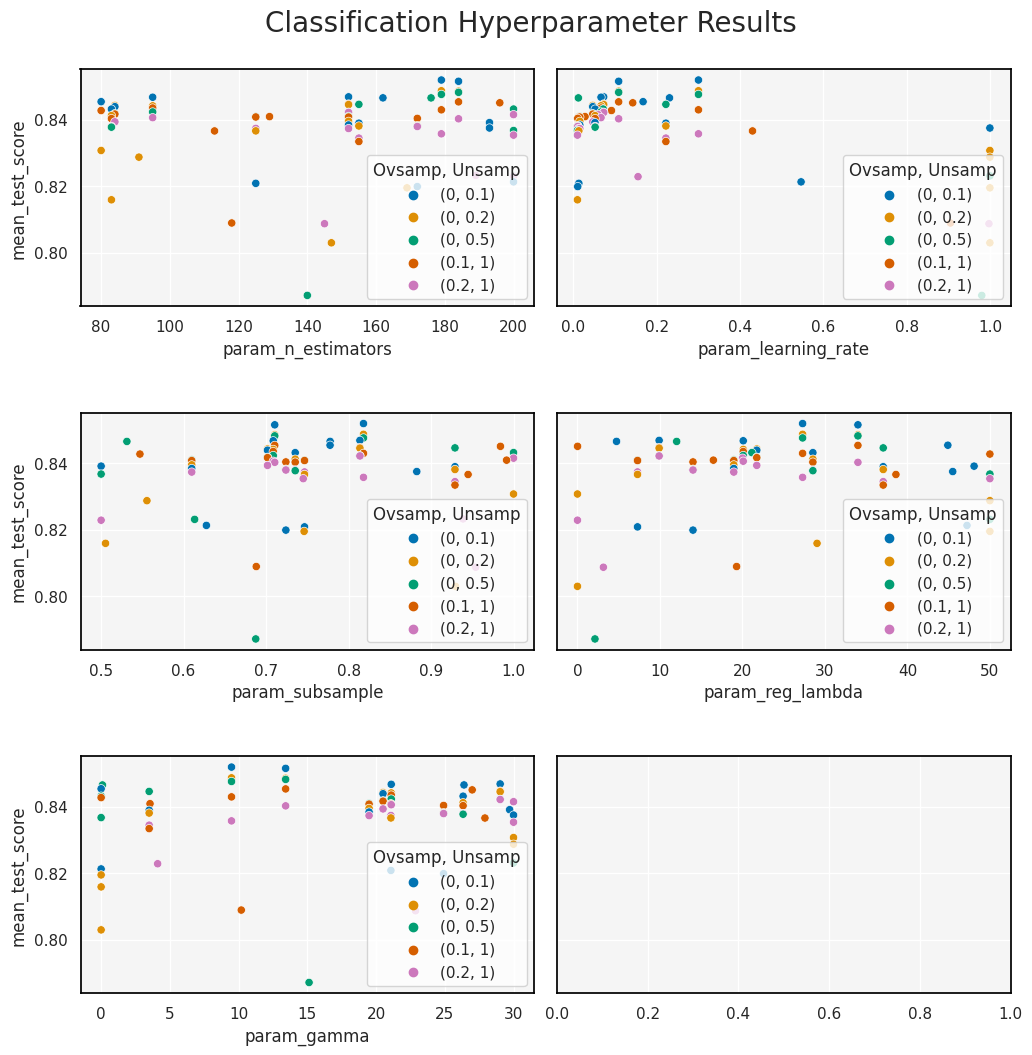

In [20]:
# Plotting the results for different hyperparameters and sets of features

sns.set_theme(
    rc={"axes.facecolor": "whitesmoke", "axes.edgecolor": "black"}, font_scale=1
)

fig, axs = plt.subplots(3, 2, figsize=(12, 12), sharey=True)

for i, (param_category, ax) in enumerate(zip(search_space_xg, axs.ravel())):
    sns.scatterplot(
        data=results_df_xg,
        x="param_" + param_category,
        y="mean_test_score",
        hue="ovsamp_unsamp",
        palette="colorblind",
        ax=ax,
    )
    ax.legend(facecolor="white", loc="lower right").set_title("Ovsamp, Unsamp")

plt.subplots_adjust(wspace=0.05, hspace=0.45)
fig.suptitle("Classification Hyperparameter Results", y=0.93, fontsize=20);

## Section 4 - Final Model

Combining the results from 5 different cross-validation runs

In [21]:
# Setting the over sampling and undersampling strategy
OV_SAMP, UN_SAMP = best_samp_strat_xg

In [22]:
# Running 5-fold cross validation on the model using the best hyperparameters and storing the results

_, _, _, df_train_x, df_train_y, df_test_x, df_test_y = kfolds_func(
    X, Y, ovsamp_strat=OV_SAMP, unsamp_strat=UN_SAMP
)
Y_pred_list, Y_proba_list, Y_validate_list = list(), list(), list()

# Looping through each of the 5 folds for cross validation
for k in df_train_x.keys():
    # Fitting a model with the best hyperparamters
    XGB_best_model = XGBClassifier(**best_params_xg, random_state=1)
    XGB_best_model.fit(df_train_x[k], df_train_y[k]["target"])

    # Storing predictions of each cross-validation in a list to later be concatenated
    Y_pred_list.append(XGB_best_model.predict(df_test_x[k]))
    Y_proba_list.append(XGB_best_model.predict_proba(df_test_x[k]))
    Y_validate_list.append(df_test_y[k]["target"])

# Concatenating the predictions from each of the 5 runs
Y_pred = np.concatenate(Y_pred_list)
Y_proba = np.concatenate(Y_proba_list)
Y_validate = np.concatenate(Y_validate_list)
# Preparing ROC AUC scores on the combined results
roc_auc = roc_auc_score(Y_validate, Y_proba[:, 1])
fpr, tpr, _ = roc_curve(Y_validate, Y_proba[:, 1], pos_label=1)

In [23]:
# Fitting the final model on the entire dataset

# Applying the best hyperparamters
X_final, Y_final = sampling_func(X, Y, ovsamp_strat=OV_SAMP, unsamp_strat=UN_SAMP)
XGB_final_model = XGBClassifier(**best_params_xg, random_state=1)
XGB_final_model.fit(X_final, Y_final["target"])

# Saving final model to drive
pickle.dump(XGB_final_model, open("saved_xgb_model", "wb"))

## Section 5 - Results


**Metrics for threshold value of 7.5%**
╒══════════════════════╤═══════════════════════╤═══════════╕
│ True Positive Rate   │ False Positive Rate   │ ROC AUC   │
╞══════════════════════╪═══════════════════════╪═══════════╡
│ 74.9%                │ 20.3%                 │ 85.1%     │
╘══════════════════════╧═══════════════════════╧═══════════╛



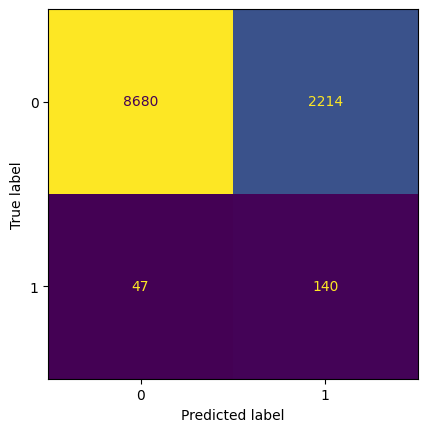

In [29]:
# Setting a threshold to evaluate model performance at a specific point
# Results reflect combined predictions from 5 different runs

PROBA_THRESHOLD = 0.075
Y_pred = (Y_proba[:, 1] >= PROBA_THRESHOLD).astype(int)

# Confusion matrix values divided by 5, as the results are combined from 5 runs
conf_mat = confusion_matrix(Y_validate, Y_pred) // 5
TPR = conf_mat[1, 1] / (conf_mat[1, 1] + conf_mat[1, 0])
FPR = conf_mat[0, 1] / (conf_mat[0, 1] + conf_mat[0, 0])

metrics_table = [
    ["True Positive Rate", "False Positive Rate", "ROC AUC"],
    [f"{TPR:.1%}", f"{FPR:.1%}", f"{roc_auc:.1%}"],
]
conf_mat_display = ConfusionMatrixDisplay(confusion_matrix=conf_mat)

print(
    f"""
**Metrics for threshold value of {PROBA_THRESHOLD:.1%}**
{tabulate(metrics_table, headers="firstrow", tablefmt="fancy_grid")}
"""
)

plt.rcdefaults()

conf_mat_display.plot(colorbar=False);

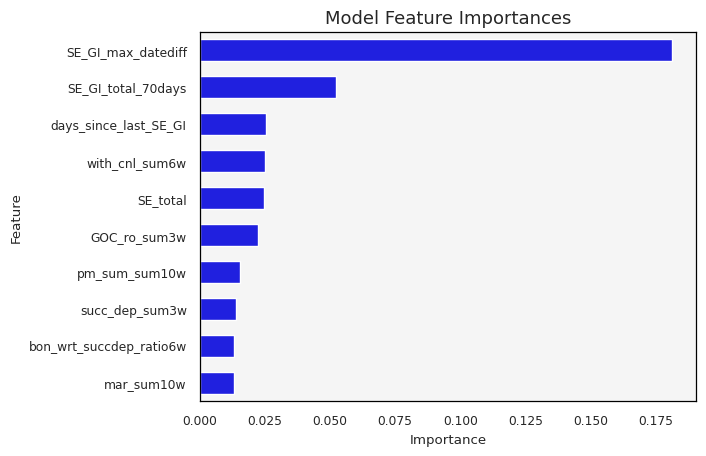

In [30]:
# Creating dataframe with features ranked by importance
feature_importance_df = (
    pd.DataFrame(
        {"Feature": X_final.columns, "Importance": XGB_final_model.feature_importances_}
    )
    .sort_values("Importance", ascending=False)
    .reset_index()
)

# Plotting top 10 features with their importance %
sns.set_theme(
    rc={
        "axes.facecolor": "whitesmoke",
        "axes.edgecolor": "black",
        "axes.linewidth": 0.9,
        "axes.grid": False,
    },
    font_scale=0.8,
)

sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance_df[0:10],
    color="blue",
    width=0.6,
)
plt.title("Model Feature Importances", fontsize=13);

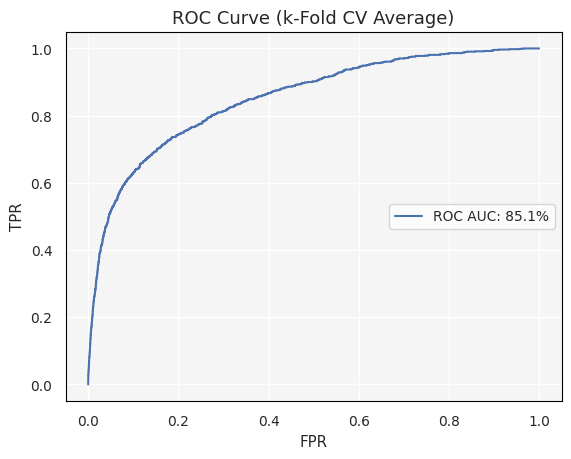

In [31]:
# Plotting the ROC Curve

sns.set_theme(
    rc={
        "axes.facecolor": "whitesmoke",
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
    },
    font_scale=0.9,
)

plt.plot(fpr, tpr, label=f"ROC AUC: {roc_auc:.1%}")
plt.title("ROC Curve (k-Fold CV Average)", fontsize=13)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(facecolor="white", loc="center right");